In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib

%pylab inline
pd.set_option('display.mpl_style', 'default') 
pd.set_option('display.line_width', 5000) 
pd.set_option('display.max_columns', 60) 
matplotlib.rcParams.update({'font.size': 15})
figsize(15, 5)

BASE_DIR = "../data/evaluation_results"

Populating the interactive namespace from numpy and matplotlib


# Analyze Summary CSV

In [2]:
results = pd.read_csv(os.path.join(BASE_DIR, "random_forest_d15_n5_result.csv"), sep=", ")
results = results.set_index(["lat", "lon"])
results

,,mse,rmse,mspe,rmspe,mpe
lat,lon,,,,,
40.78,-73.95,3271.771787,57.199404,0.851862,0.922964,0.127120
40.74,-73.98,5354.772990,73.176314,3.030807,1.740921,0.152041
40.76,-73.96,1741.996330,41.737230,0.850380,0.922160,0.145139
40.74,-73.99,8787.928016,93.743949,2.098351,1.448569,0.125469
40.80,-73.95,59.389127,7.706434,0.279372,0.528557,0.299139
40.73,-74.01,792.538770,28.152065,1.789755,1.337817,0.177854
40.77,-73.92,42.820466,6.543735,1.436711,1.198629,0.583911
40.76,-73.93,30.037393,5.480638,1.048645,1.024034,0.533692
40.78,-73.99,184.690411,13.590085,0.575040,0.758314,0.344321


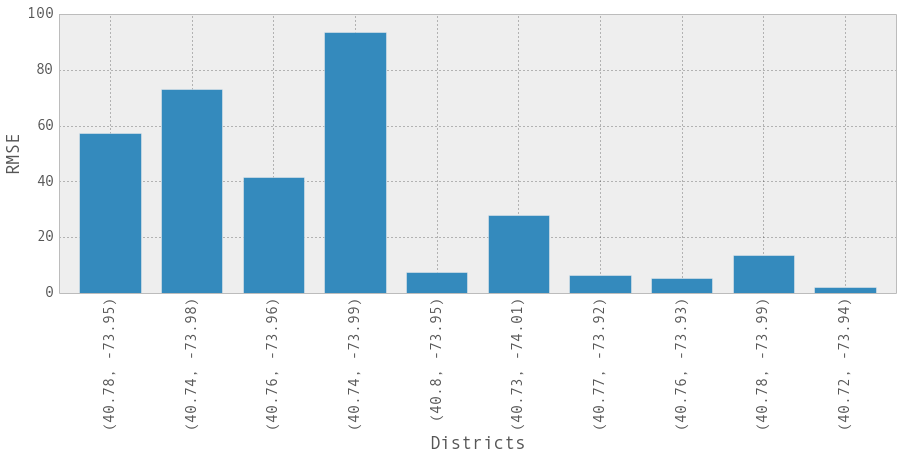

In [3]:
ax = results["rmse"].plot(kind="bar")
ax.set_xlabel("Districts")
ax.set_ylabel("RMSE")

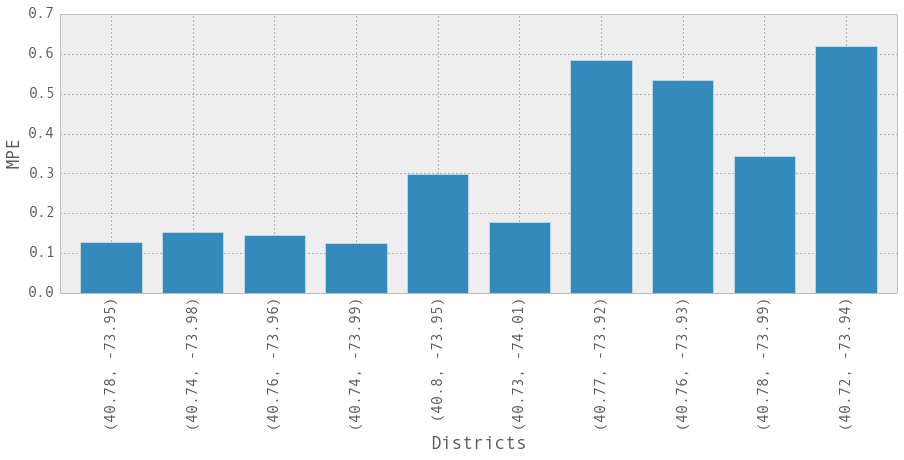

In [4]:
ax = results["mpe"].plot(kind="bar")
ax.set_xlabel("Districts")
ax.set_ylabel("MPE")

# Load and sanity check data

In [5]:
DISTRICT_CSV = "random_forest_d15_n5_%s.csv"

DISTRICTS = [
    "40.72_-73.94",
    "40.73_-74.01",
    "40.74_-73.98",
    "40.74_-73.99",
    "40.76_-73.93",
    "40.76_-73.96",
    "40.77_-73.92",
    "40.78_-73.95",
    "40.78_-73.99",
    "40.8_-73.95",
]

In [6]:
all_data = {}
for district in DISTRICTS:
    district_data = pd.read_csv(os.path.join(BASE_DIR, DISTRICT_CSV % district),
                                sep=", ",
                                parse_dates=["time"],
                                index_col="time")
    district_data["day"] = district_data.index.dayofyear
    district_data["week"] = district_data.index.week
    district_data["district"] = district
    district_data = district_data.sort()
    
    all_data[district] = district_data

all_data[DISTRICTS[3]][:5]

,prediction,label,day,week,district
time,,,,,
2015-01-01 01:00:00,1317.195425,819,1,1,40.74_-73.99
2015-01-01 02:00:00,1121.743277,625,1,1,40.74_-73.99
2015-01-01 03:00:00,809.000000,738,1,1,40.74_-73.99
2015-01-01 04:00:00,416.611111,519,1,1,40.74_-73.99
2015-01-01 05:00:00,257.666667,276,1,1,40.74_-73.99


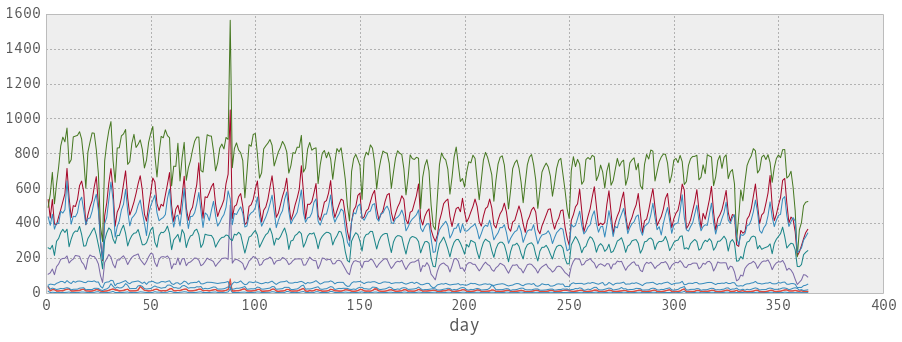

In [7]:
for district in DISTRICTS:
    daily_average = all_data[district].groupby(["day"]).mean()["label"]
    daily_average.plot()

# Compute Hourly Error Measures

In [8]:
for district in DISTRICTS:
    data = all_data[district]
    
    # Prevent division by zero
    label_or_one = np.max(data["label"], 1)

    data["absolute_error"] = np.abs(data["label"] - data["prediction"])
    data["squared_error"] = data["absolute_error"] * data["absolute_error"]
    data["proportional_error"] = data["absolute_error"] / label_or_one
    data["squared_proportional_error"] = data["proportional_error"] * data["proportional_error"]
    
    all_data[district] = data
    
all_data[DISTRICTS[3]][:5]

,prediction,label,day,week,district,absolute_error,squared_error,proportional_error,squared_proportional_error
time,,,,,,,,,
2015-01-01 01:00:00,1317.195425,819,1,1,40.74_-73.99,498.195425,248198.681491,0.257067,0.066083
2015-01-01 02:00:00,1121.743277,625,1,1,40.74_-73.99,496.743277,246753.883245,0.256317,0.065699
2015-01-01 03:00:00,809.000000,738,1,1,40.74_-73.99,71.000000,5041.000000,0.036636,0.001342
2015-01-01 04:00:00,416.611111,519,1,1,40.74_-73.99,102.388889,10483.484591,0.052832,0.002791
2015-01-01 05:00:00,257.666667,276,1,1,40.74_-73.99,18.333333,336.111099,0.009460,0.000089


# Compute Daily Error Measures

In [9]:
daily_errors = {}

for district in DISTRICTS:
    errors = all_data[district][["day", "squared_error", "proportional_error", "squared_proportional_error"]]\
             .groupby("day").mean()
    errors.columns = ["MSE", "MPE", "MSPE"]
    errors["RMSE"] = np.sqrt(errors["MSE"])
    errors["RMSPE"] = np.sqrt(errors["MSPE"])
    
    daily_errors[district] = errors

daily_errors[DISTRICTS[3]][:5]

,MSE,MPE,MSPE,RMSE,RMSPE
day,,,,,
1,24088.851130,0.041302,0.006414,155.205835,0.080086
2,3412.211558,0.024797,0.000909,58.414138,0.030141
3,4344.094172,0.025204,0.001157,65.909743,0.034009
4,3719.031286,0.024064,0.000990,60.983861,0.031467
5,6494.126431,0.028570,0.001729,80.586143,0.041582


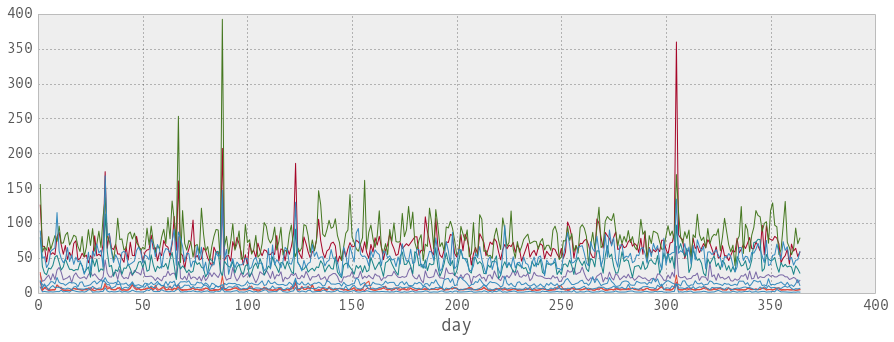

In [10]:
for district in DISTRICTS:
    daily_errors[district]["RMSE"].plot()

We can see that the different Error Measures correlate very strongly:

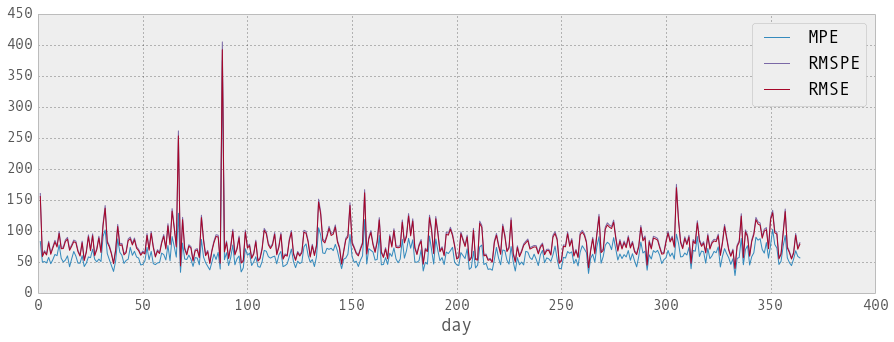

In [11]:
sample_district = DISTRICTS[3]
pd.concat([daily_errors[sample_district][["MPE", "RMSPE"]] * 2000,
           daily_errors[sample_district][["RMSE"]]], axis=1).plot()

# Compute Best and Worst Days

We use MSPE as the performance measure.

In [12]:
worst_days = {}
best_days = {}

for district in DISTRICTS:
    worst_days[district] = daily_errors[district]["MPE"].argmax()
    best_days[district] = daily_errors[district]["MPE"].argmin()

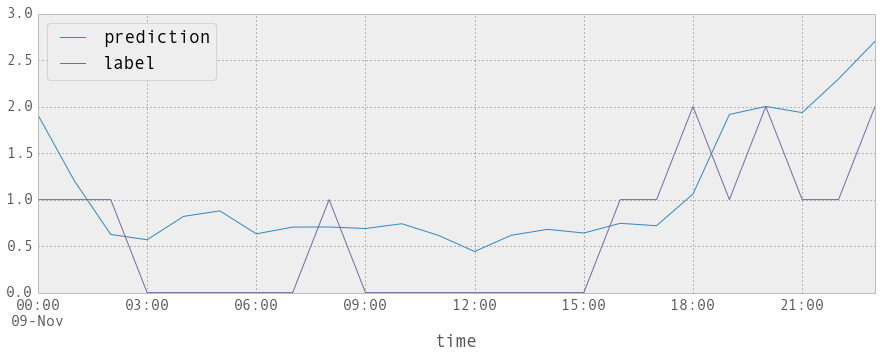

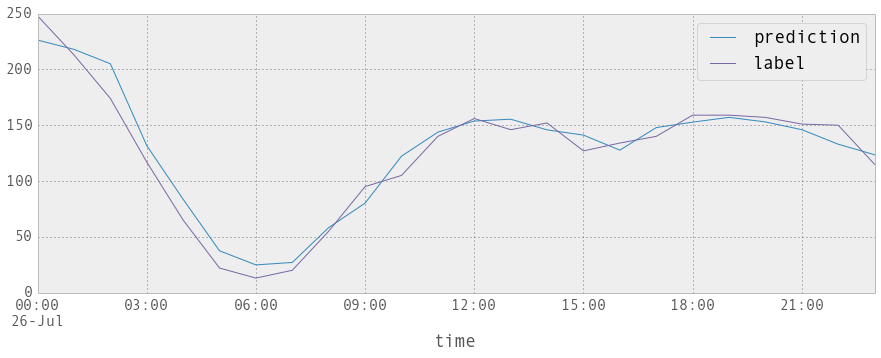

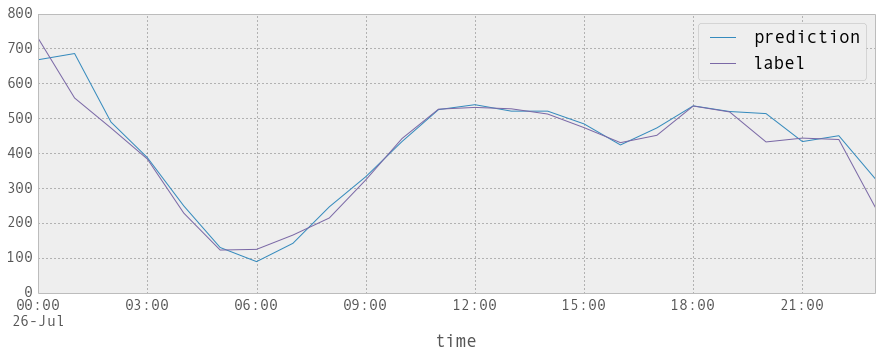

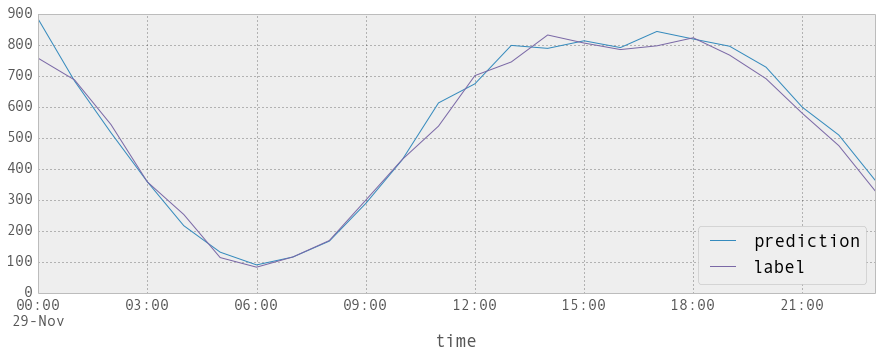

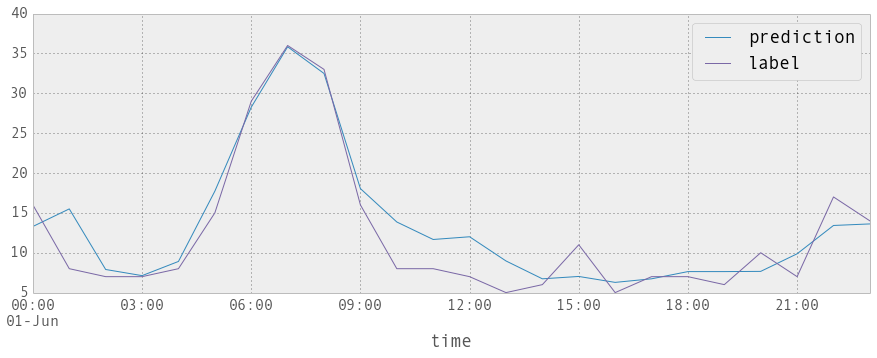

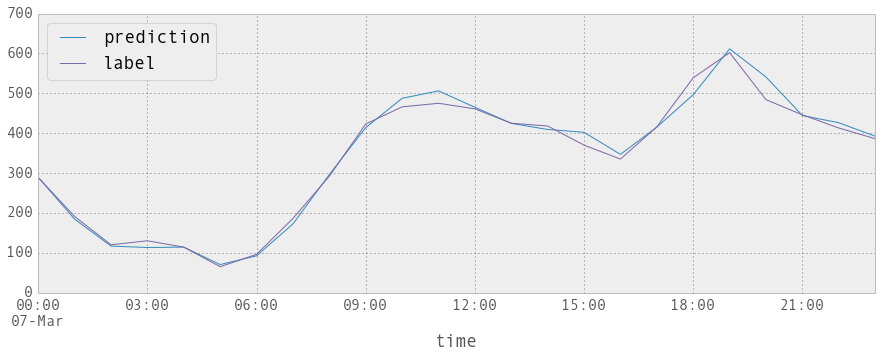

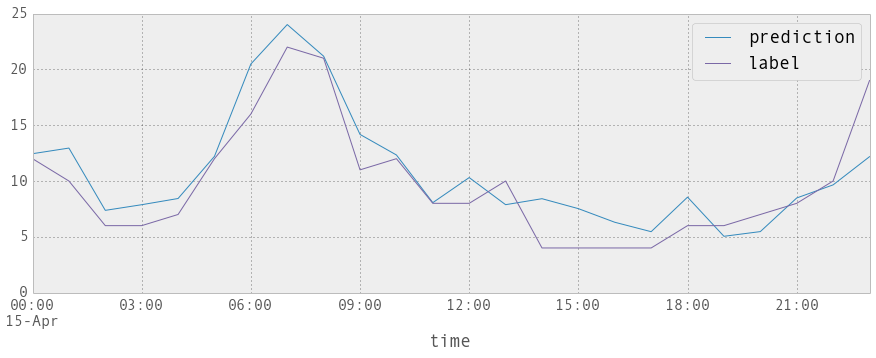

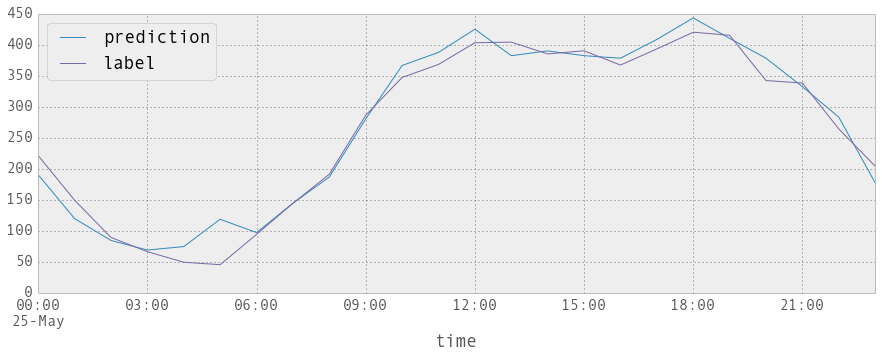

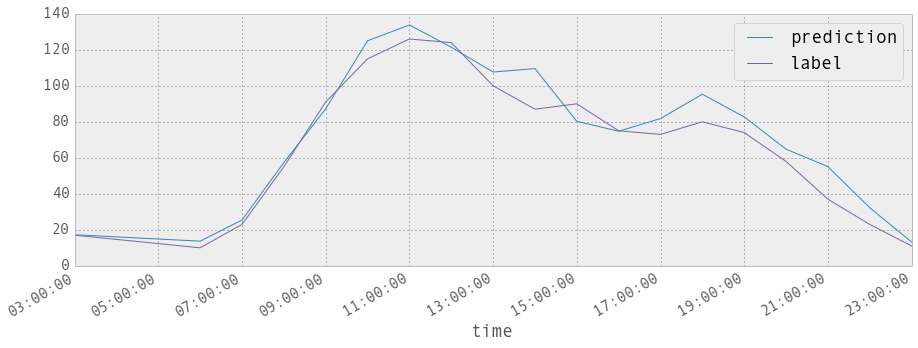

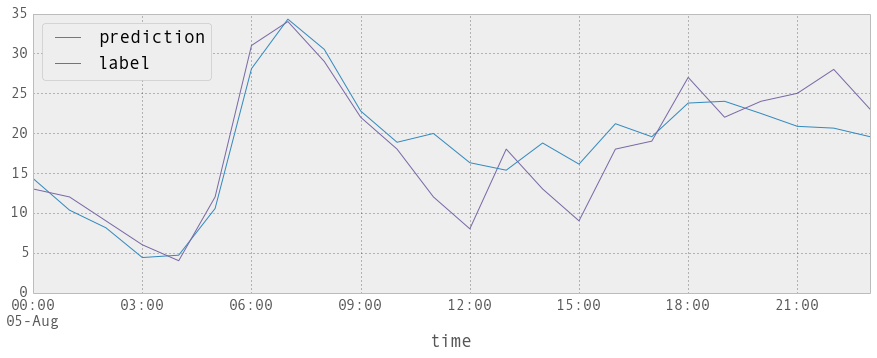

In [13]:
for district in DISTRICTS:
    data = all_data[district]
    data[data["day"] == best_days[district]][["prediction", "label"]].plot()

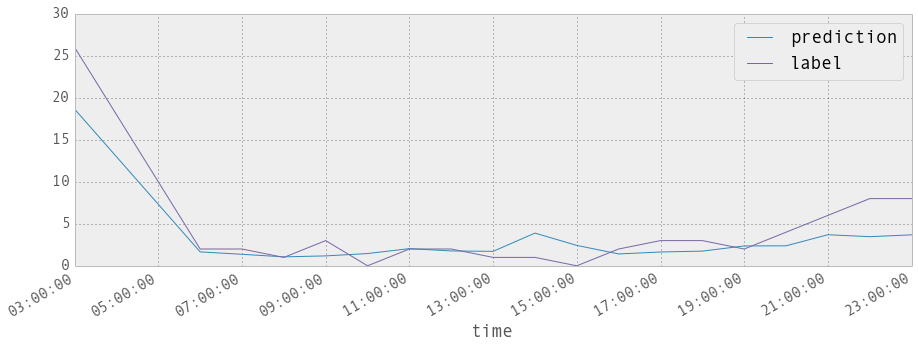

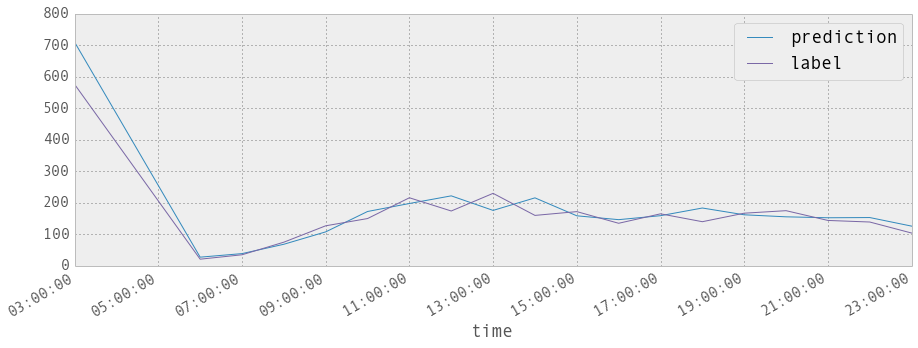

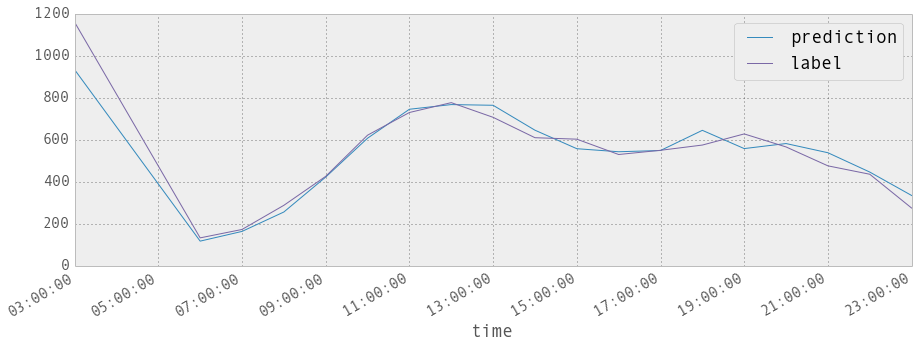

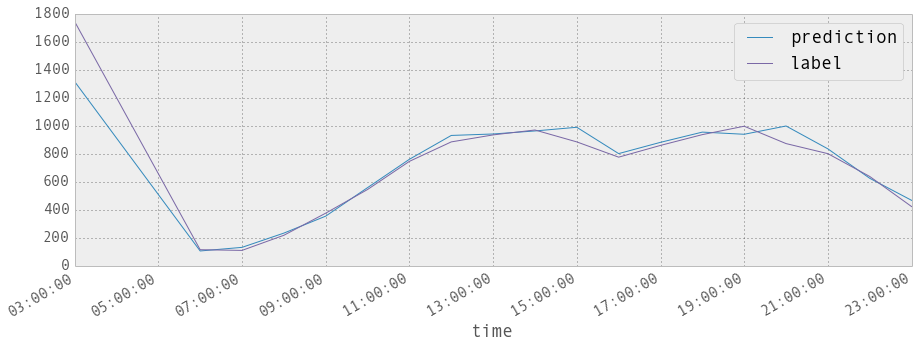

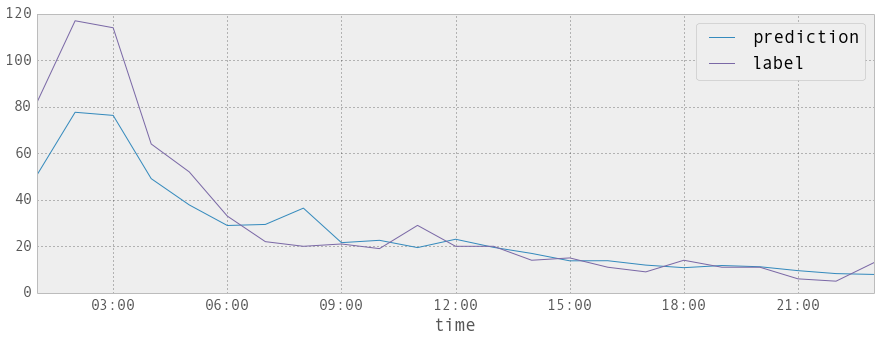

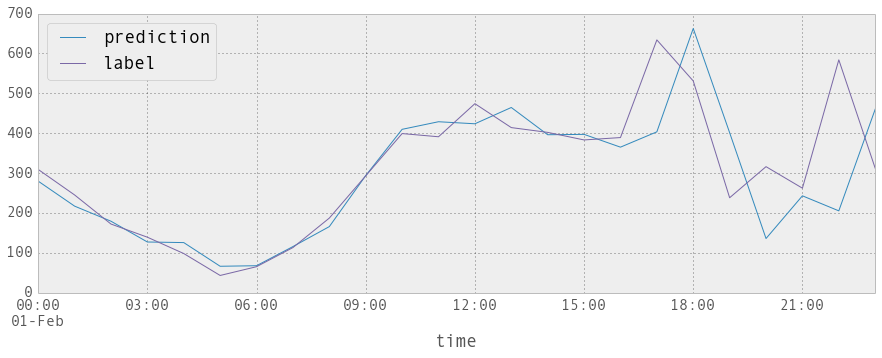

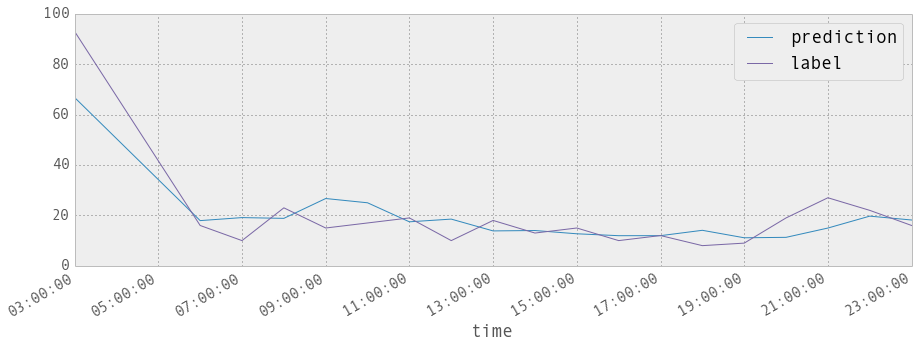

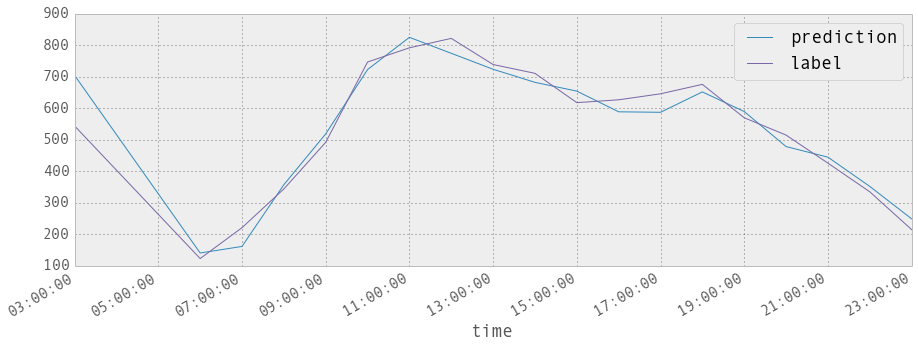

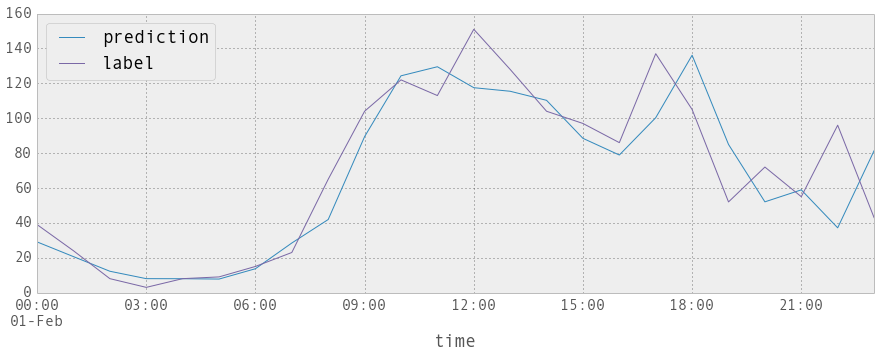

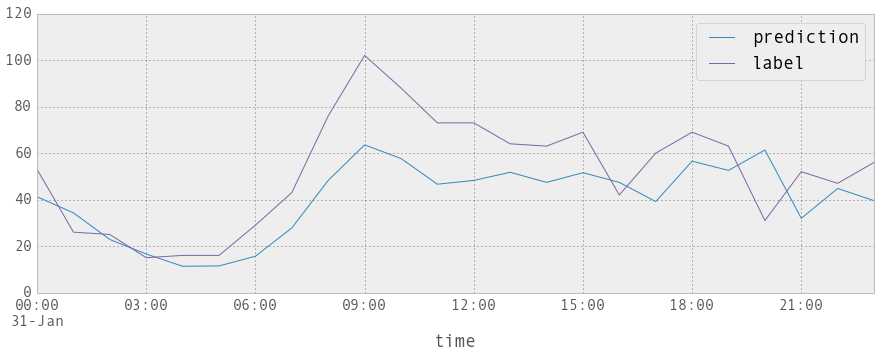

In [14]:
for district in DISTRICTS:
    data = all_data[district]
    data[data["day"] == worst_days[district]][["prediction", "label"]].plot()

# Compute Best and Worst Weeks

In [15]:
weekly_errors = {}

for district in DISTRICTS:
    errors = all_data[district][["week", "squared_error", "proportional_error", "squared_proportional_error"]]\
             .groupby("week").mean()
    errors.columns = ["MSE", "MPE", "MSPE"]
    errors["RMSE"] = np.sqrt(errors["MSE"])
    errors["RMSPE"] = np.sqrt(errors["MSPE"])
    
    weekly_errors[district] = errors

weekly_errors[DISTRICTS[3]][:5]

,MSE,MPE,MSPE,RMSE,RMSPE
week,,,,,
1,8731.070151,0.028710,0.002325,93.440196,0.048215
2,5993.848716,0.029444,0.001596,77.419950,0.039948
3,6156.182266,0.027482,0.001639,78.461342,0.040486
4,4885.446002,0.025743,0.001301,69.895966,0.036066
5,8592.574580,0.033843,0.002288,92.696141,0.047831


In [16]:
worst_weeks = {}
best_weeks = {}

for district in DISTRICTS:
    errors = weekly_errors[district]
    # Remove first and last week
    errors = errors[errors.index != 1]
    errors = errors[errors.index != 53]
    worst_weeks[district] = errors["MPE"].argmax()
    best_weeks[district] = errors["MPE"].argmin()

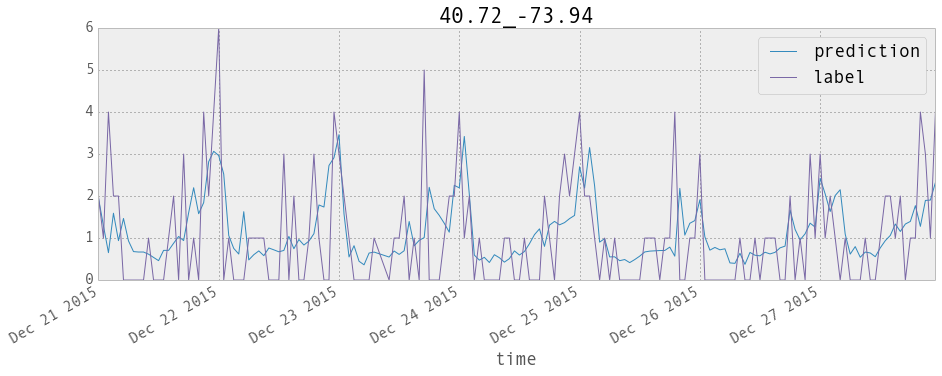

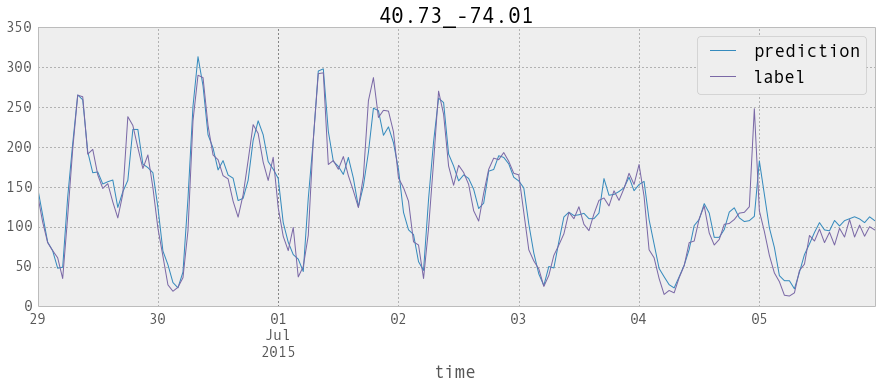

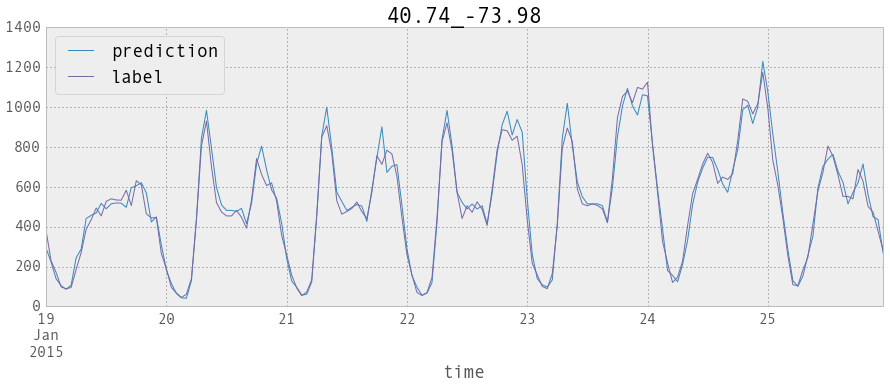

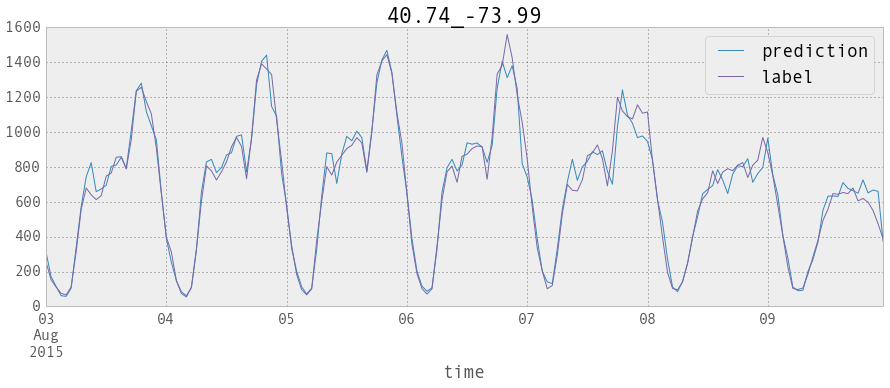

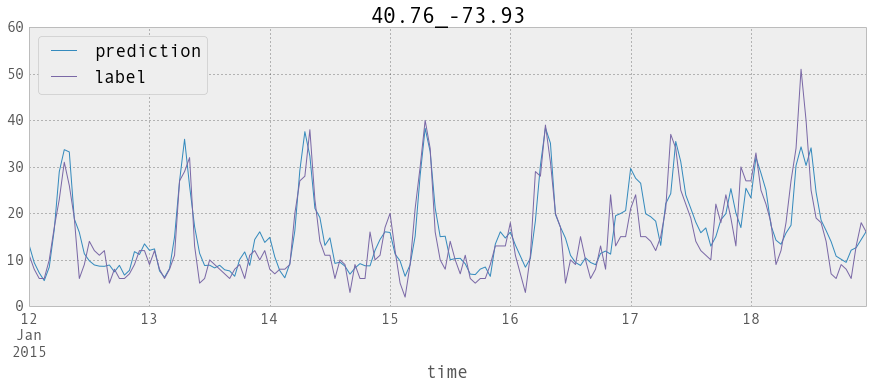

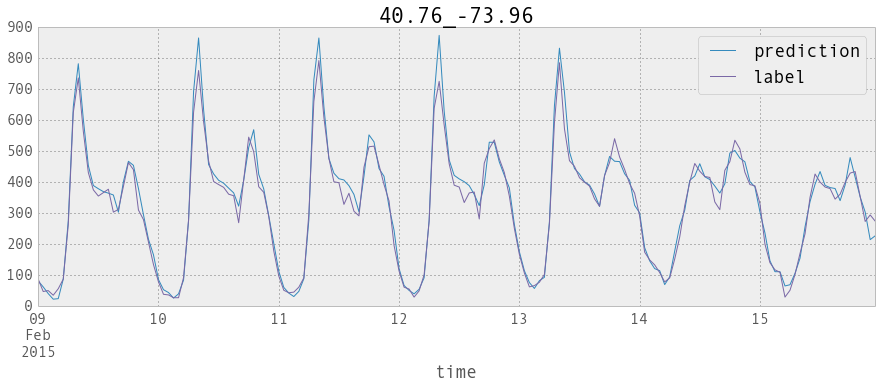

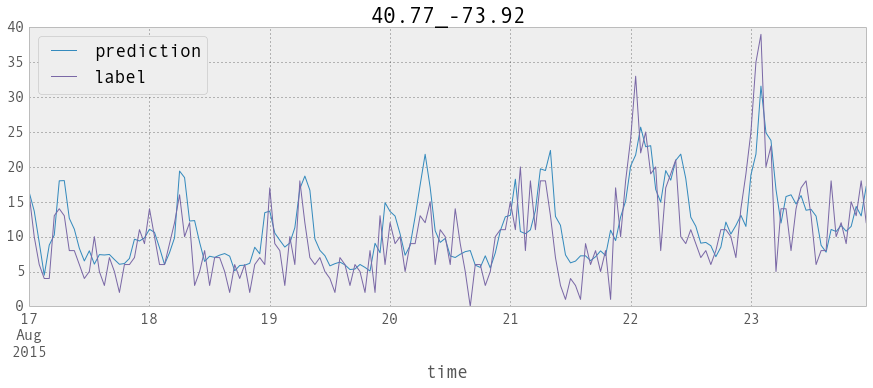

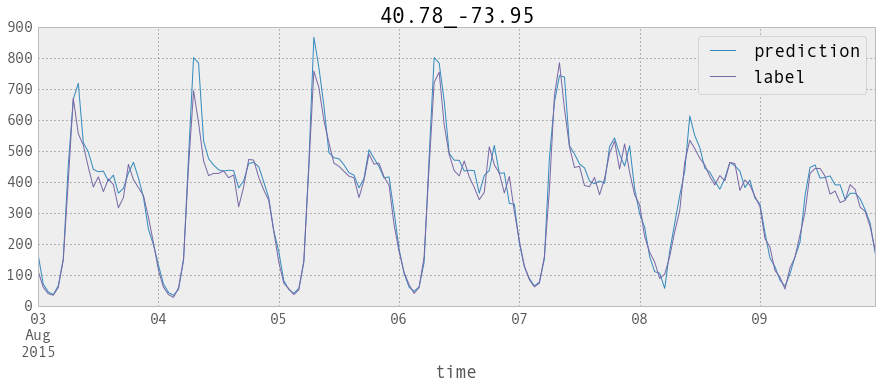

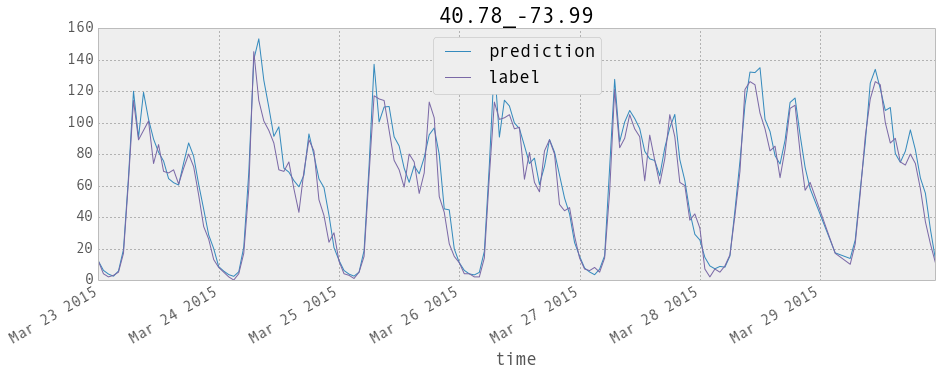

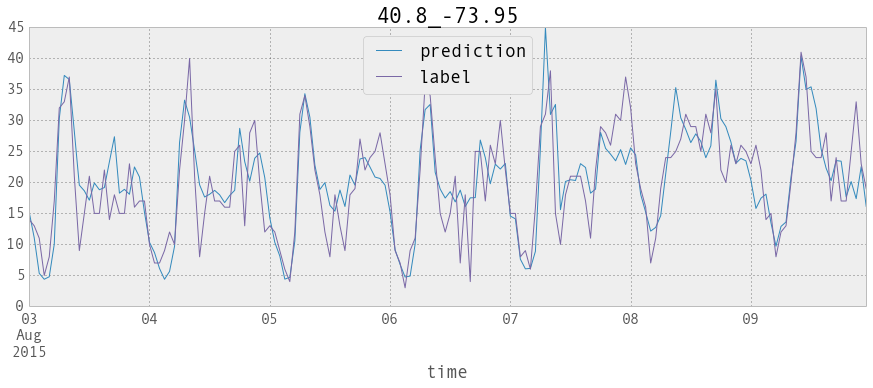

In [17]:
for district in DISTRICTS:
    data = all_data[district]
    data[data["week"] == best_weeks[district]][["prediction", "label"]].plot(title=district)

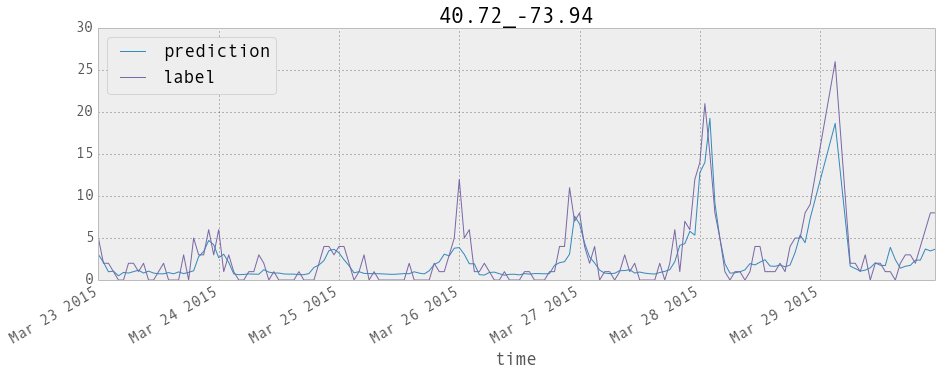

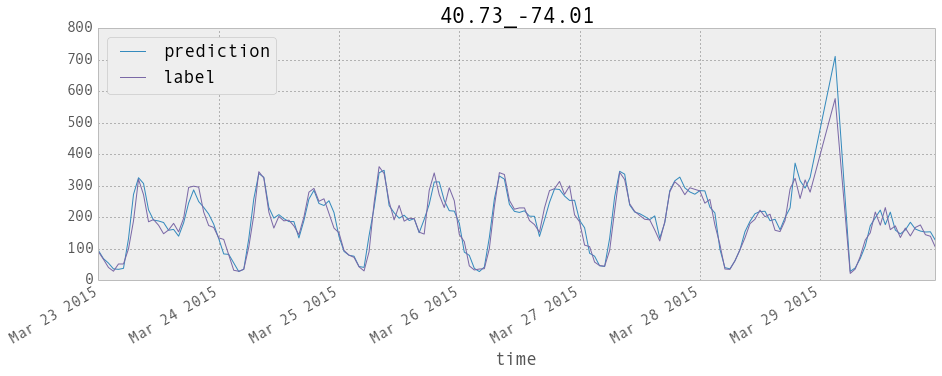

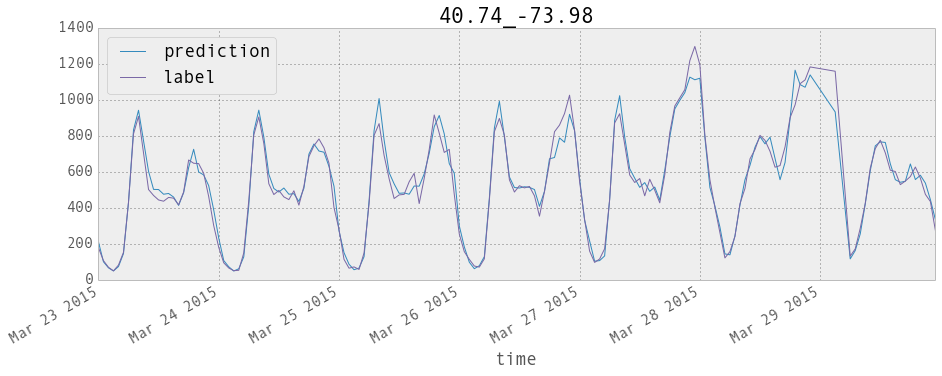

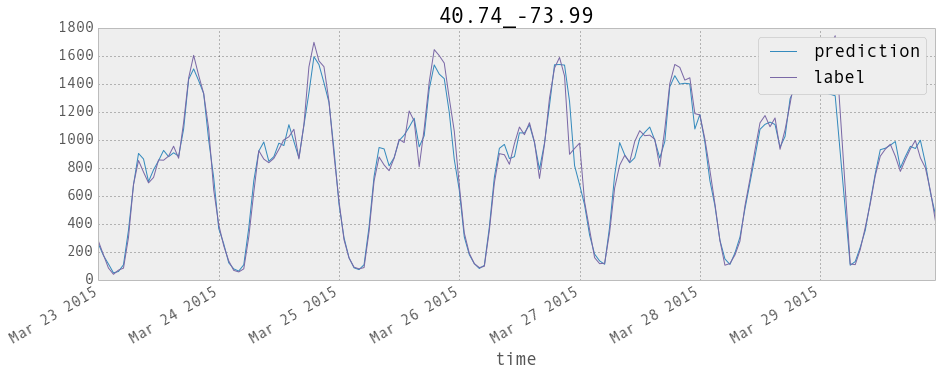

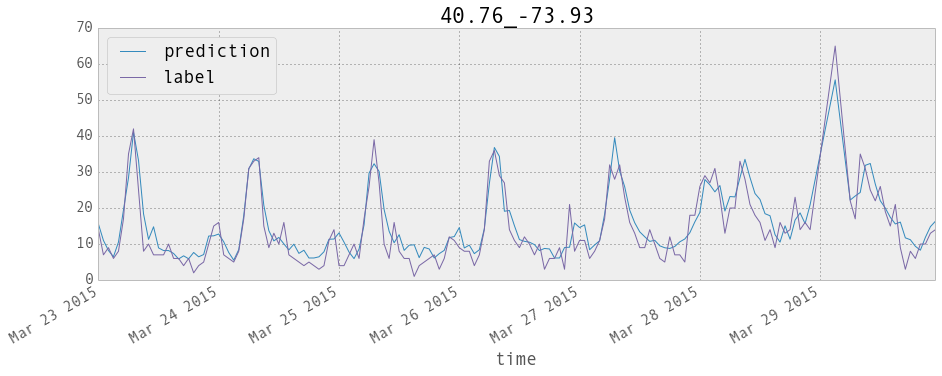

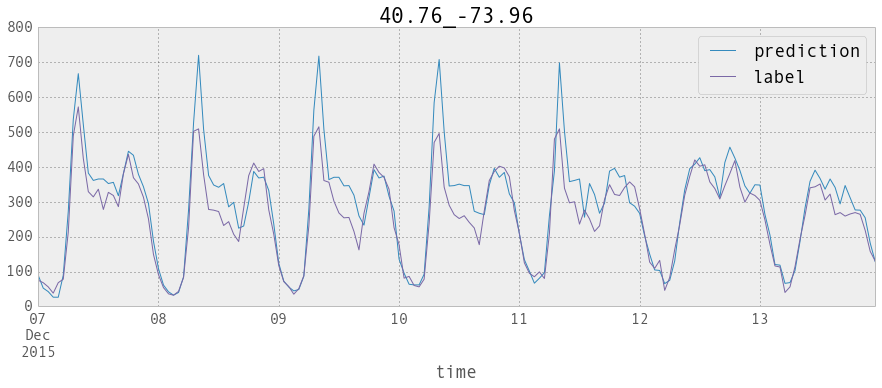

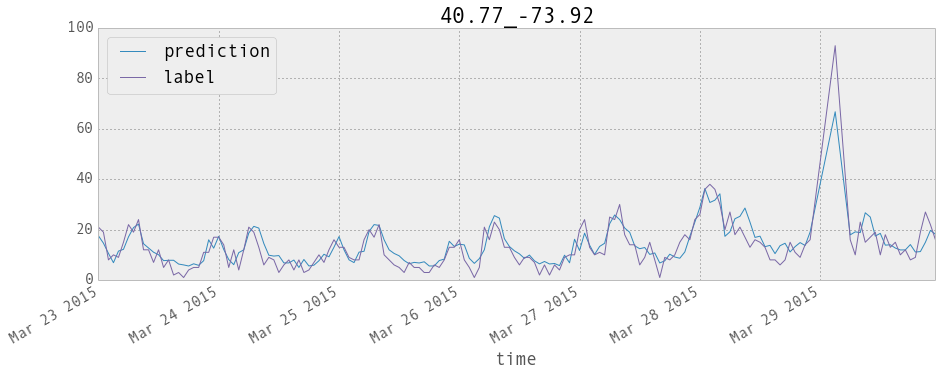

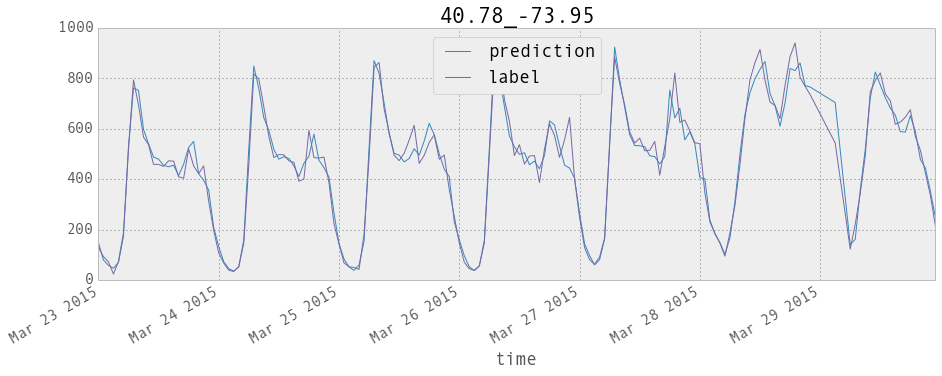

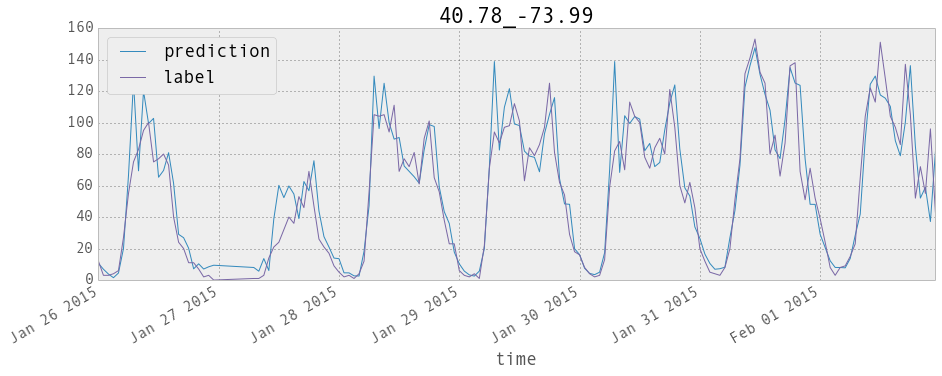

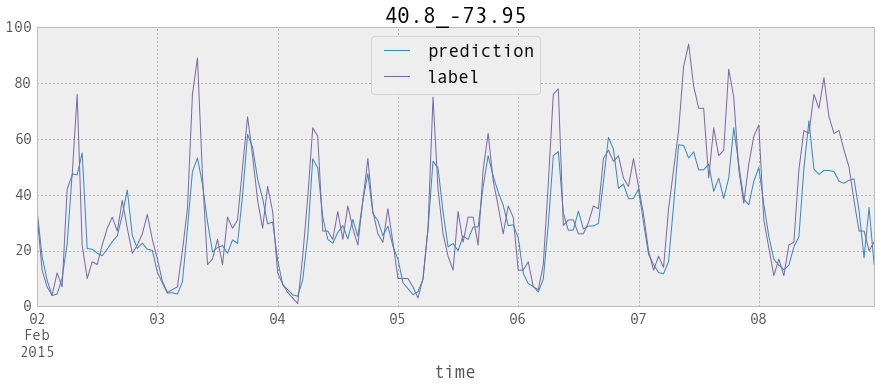

In [18]:
for district in DISTRICTS:
    data = all_data[district]
    data[data["week"] == worst_weeks[district]][["prediction", "label"]].plot(title=district, fontsize=5)